# Business Problem: Reducing Revenue Loss from Customer Churn

Scenario:

The company’s CFO reports a year-on-year increase in customer churn that’s causing a measurable dip in monthly recurring revenue (MRR). Despite acquiring new customers, retention rates are dropping—especially among long-tenure clients who switch to competitors offering better bundled deals or service quality.


# Goal :
📍 Identify the behavioral and demographic patterns behind churn

📍 Predict which customers are at highest risk

📍 Design targeted interventions to improve retention and reduce revenue leakage

# Data Exploration

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#load the dataset

data = pd.read_csv(r'WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data cleaning

In [57]:
#check for missing values
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
HighRisk            0
ChurnPropensity     0
ChurnRiskSegment    0
dtype: int64

In [58]:
#check for duplicate rows
data.duplicated().sum()

0

# 1. Descriptive Statistic

* Churn Distribution

Question: What % of customers are churning overall?


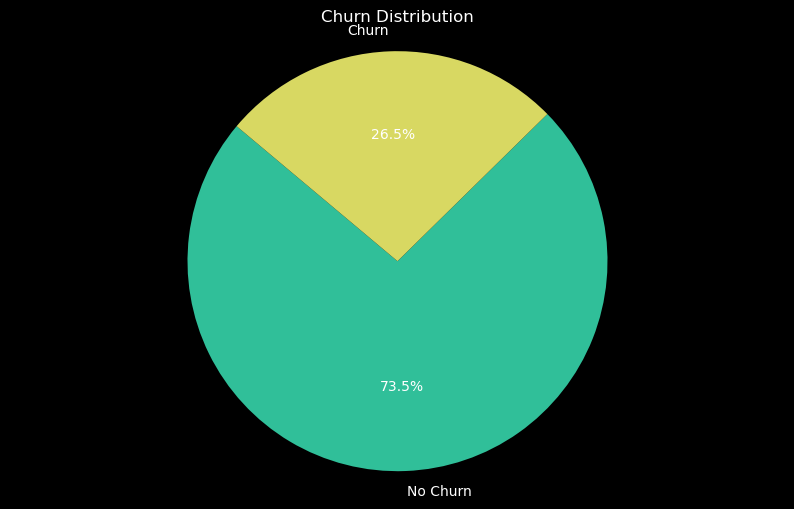

In [62]:
#percentage of churned customers doughnut chart use colors used in demographic patterns
plt.figure(figsize=(10,6))
plt.pie(data['Churn'].value_counts(), labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=140, colors=["#30BF99", "#D8D862"])
plt.title('Churn Distribution')
plt.axis('equal') 
plt.show()

* Demographic Churn Patterns

Question: Who’s most likely to churn based on age, dependents, senior citizen status, etc.?

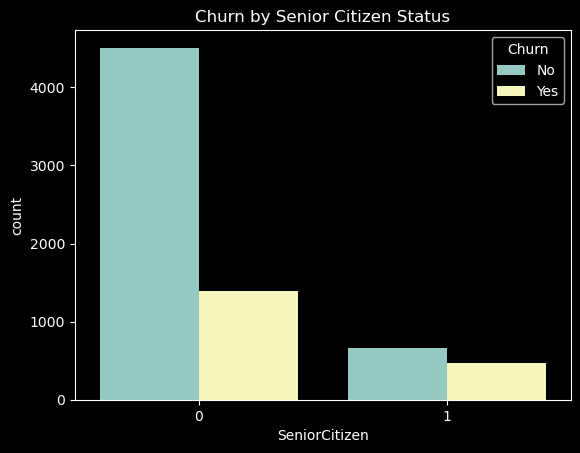

In [59]:
# Demographic Churn Patterns
sns.countplot(x='SeniorCitizen', hue='Churn', data=data)
plt.title("Churn by Senior Citizen Status")
plt.show()

# 2. Demographic Analysis

* Question: Who’s most likely to churn based on Demographic?

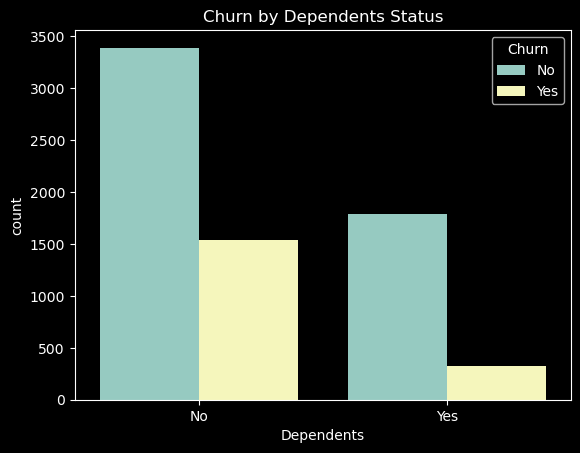

In [60]:
# Demographic Churn Patterns
sns.countplot(x='Dependents', hue='Churn', data=data)
plt.title("Churn by Dependents Status")
plt.show()

# 3. Service Usage Pattern

* Question: Do certain services correlate with higher churn?

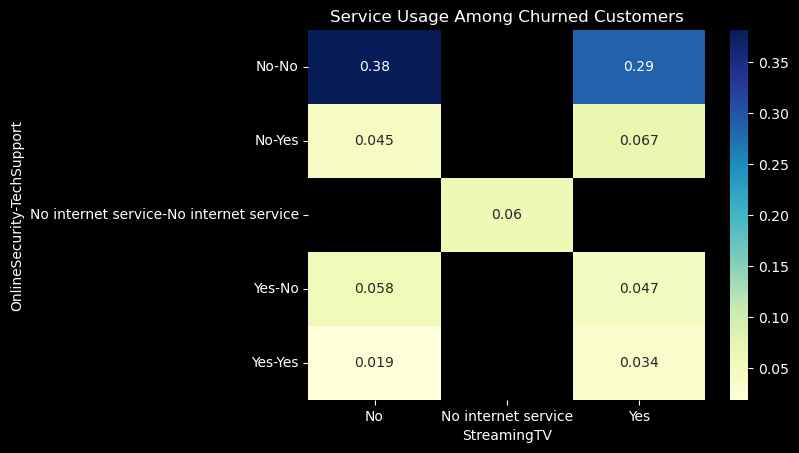

In [66]:
#heatmap
service_cols = ['OnlineSecurity', 'TechSupport', 'StreamingTV']
churn_services = data.groupby('Churn')[service_cols].apply(lambda x: x.value_counts(normalize=True)).unstack()
sns.heatmap(churn_services.loc['Yes'], annot=True, cmap="YlGnBu")
plt.title("Service Usage Among Churned Customers")
plt.show()

#  4. Payment Behavior

* Question: Are short-tenure or high-charge customers more likely to churn?

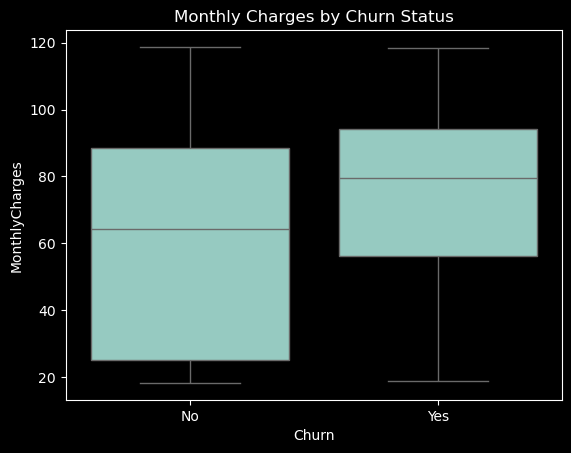

In [15]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title("Monthly Charges by Churn Status")
plt.show()

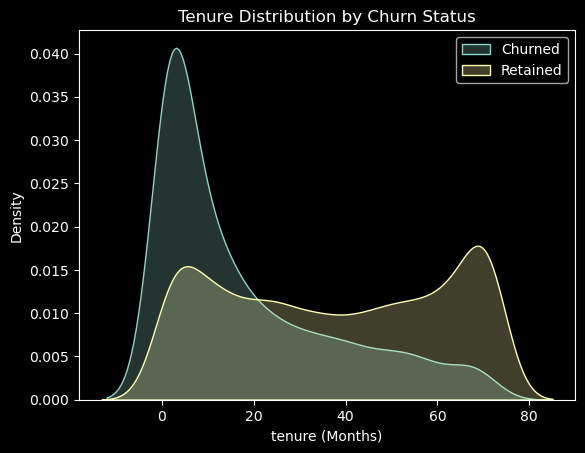

In [18]:
sns.kdeplot(data=data[data['Churn']=='Yes'], x='tenure', label='Churned', shade=True)
sns.kdeplot(data=data[data['Churn']=='No'], x='tenure', label='Retained', shade=True)
plt.title("Tenure Distribution by Churn Status")
plt.xlabel("tenure (Months)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [52]:
# save the data exploration insights to a CSV file
data.to_csv('telco_churn_exploration_insights.csv', index=False)

# Feature Engineering

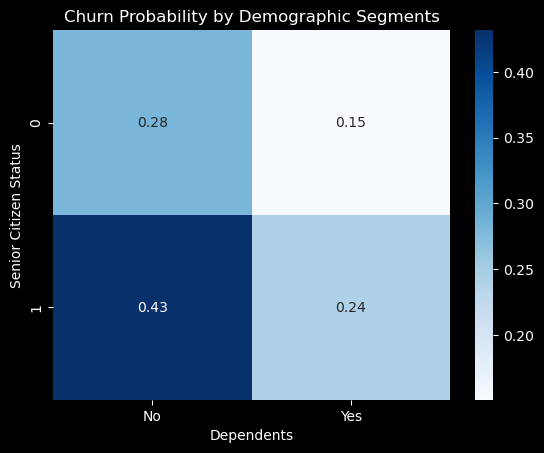

In [19]:
#create a flag for high-risk customers

data['HighRisk'] = np.where((data['Churn'] == 'Yes') & (data['MonthlyCharges'] > data['MonthlyCharges'].median()), 1, 0)
#calculate churn probability by demographic segments
churn_prob = data.groupby(['SeniorCitizen', 'Dependents'])['Churn'].value_counts(normalize=True).unstack().fillna(0)
churn_prob['Churn Probability'] = churn_prob['Yes']
churn_prob = churn_prob.reset_index()
churn_prob = churn_prob.pivot(index='SeniorCitizen', columns='Dependents', values='Churn Probability')
sns.heatmap(churn_prob, annot=True, cmap='Blues')
plt.title("Churn Probability by Demographic Segments")
plt.xlabel("Dependents")
plt.ylabel("Senior Citizen Status")
plt.show()

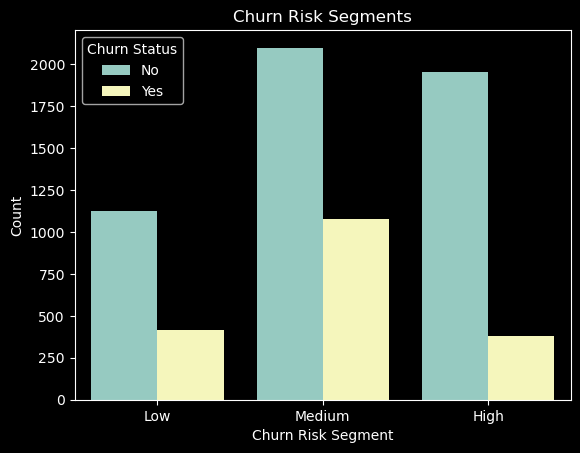

In [25]:
#Simulate a churn propensity score.

data['ChurnPropensity'] = (data['tenure'] / data['tenure'].max()) * 0.5 + (data['MonthlyCharges'] / data['MonthlyCharges'].max()) * 0.5
data['ChurnRiskSegment'] = pd.cut(data['ChurnPropensity'], bins=[0, 0.3, 0.6, 1], labels=['Low', 'Medium', 'High'])
sns.countplot(x='ChurnRiskSegment', hue='Churn', data=data)
plt.title("Churn Risk Segments")
plt.xlabel("Churn Risk Segment")
plt.ylabel("Count")
plt.legend(title='Churn Status')
plt.show()

In [53]:
#save feature engineering insights to a CSV file
data[['ChurnPropensity', 'ChurnRiskSegment']].to_csv('telco_churn_feature_engineering_insights.csv', index=False)

# Predictive Modeling 

 - Build a churn prediction model using  logistic regression and decision tree that includes precision-recall analysis and business implications of false positives.

#  Logistic Regression Model
Logistic regression gives you interpretable probabilities of churn risk per customer.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

In [27]:
#drop unnecessary columns
X = data.drop(['customerID', 'Churn'], axis=1) 

In [28]:
#encode categorical variables
X = pd.get_dummies(X, drop_first=True)
y = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


In [30]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
#train the logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

# Model Evaluation

In [32]:
#evaluate the model
y_pred = log_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1424  115]
 [ 222  352]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.89      1539
           1       0.75      0.61      0.68       574

    accuracy                           0.84      2113
   macro avg       0.81      0.77      0.79      2113
weighted avg       0.83      0.84      0.83      2113



* Insight : we can correctly identify 61% of churners before they leave

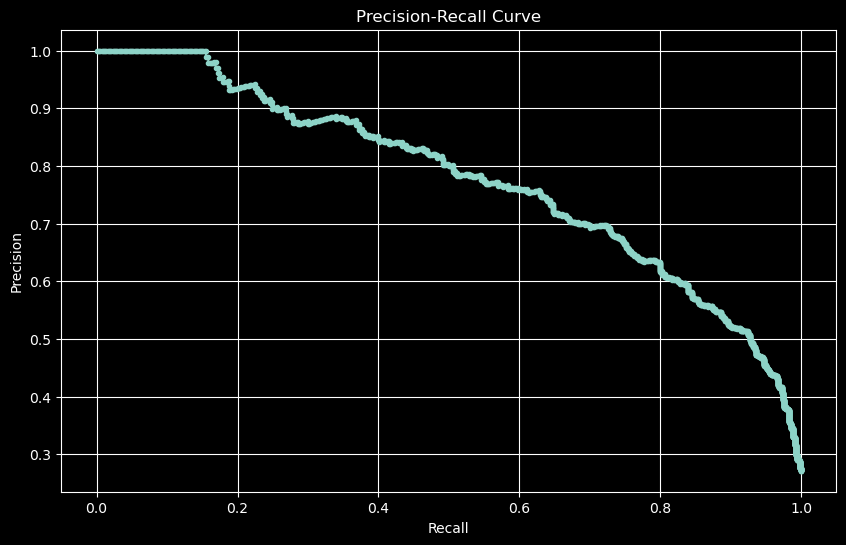

In [33]:
#precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, log_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [54]:
#save logistic regression model into a file ipynb
import joblib
joblib.dump(log_model, 'telco_churn_logistic_model.pkl')

['telco_churn_logistic_model.pkl']

# Decision Tree Model

Decision trees help visualize churn paths and simulate segmentation logic for business teams.

In [45]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [46]:
#train the decision tree model
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [47]:
#Predict and evaluate
y_dt_pred = dt_model.predict(X_test)
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_dt_pred))
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_dt_pred))


Decision Tree Confusion Matrix:
[[1427  112]
 [ 246  328]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1539
           1       0.75      0.57      0.65       574

    accuracy                           0.83      2113
   macro avg       0.80      0.75      0.77      2113
weighted avg       0.82      0.83      0.82      2113



* Insight : This model helps us proactively target churn with 75% precision, but we miss about 43% of actual churn cases. Strengthening this recall could protect up to 246 additional customers.

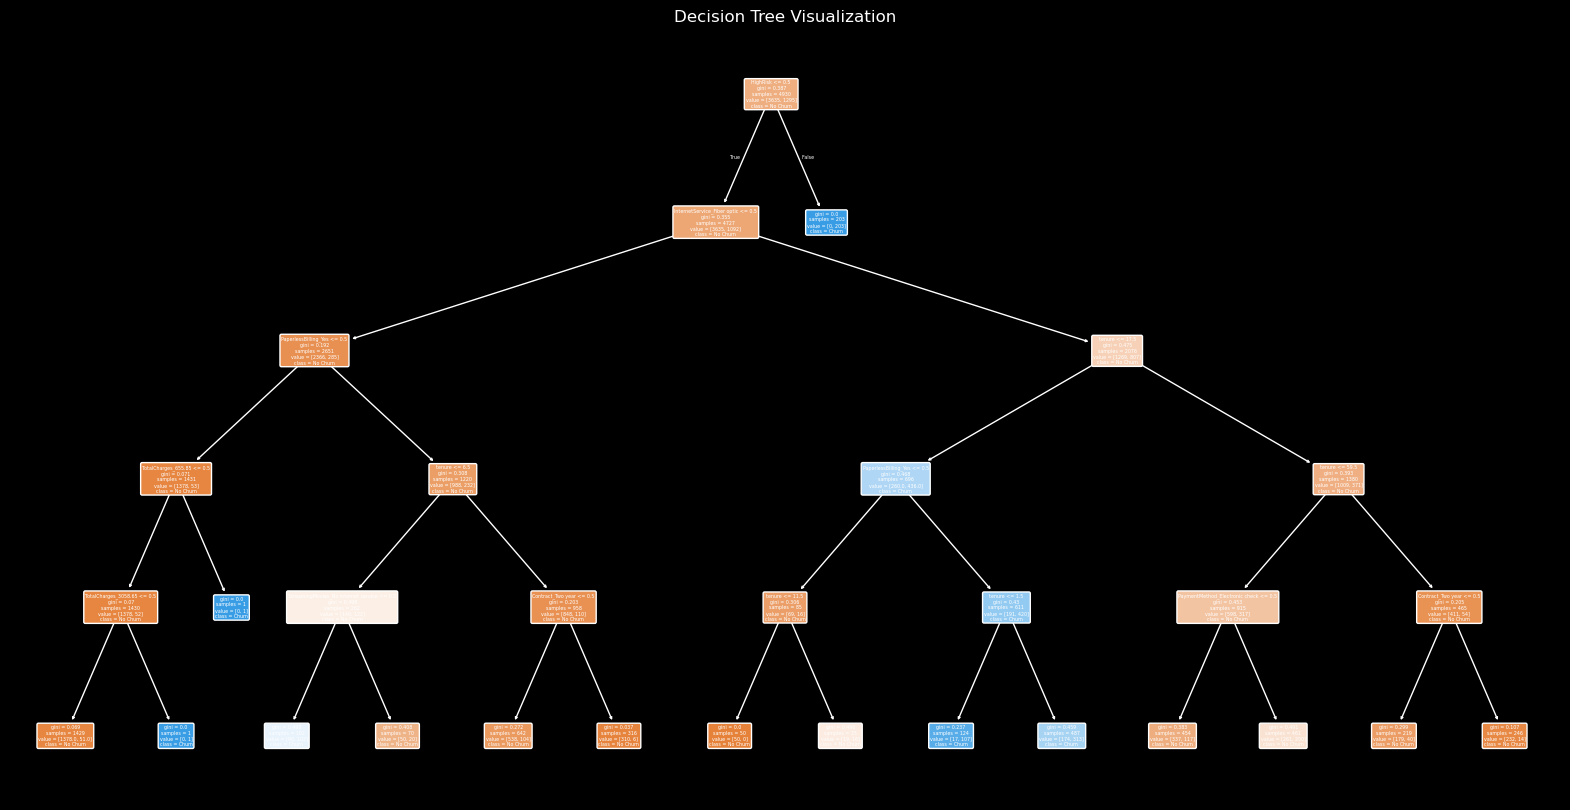

In [48]:
#plot the decision tree with labels that show the features used for splitting make it easier to understand and readable
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['No Churn', 'Churn'], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

In [55]:
#save the decision tree model into a file
joblib.dump(dt_model, 'telco_churn_decision_tree_model.pkl')

['telco_churn_decision_tree_model.pkl']

# XGBOOST model

In [49]:
# use the xgboost model
import xgboost as xgb
from xgboost import XGBClassifier

In [50]:
#train a xgboost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


XGBoost Confusion Matrix:
[[1405  134]
 [ 235  339]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1539
           1       0.72      0.59      0.65       574

    accuracy                           0.83      2113
   macro avg       0.79      0.75      0.77      2113
weighted avg       0.82      0.83      0.82      2113



<Figure size 1000x1000 with 0 Axes>

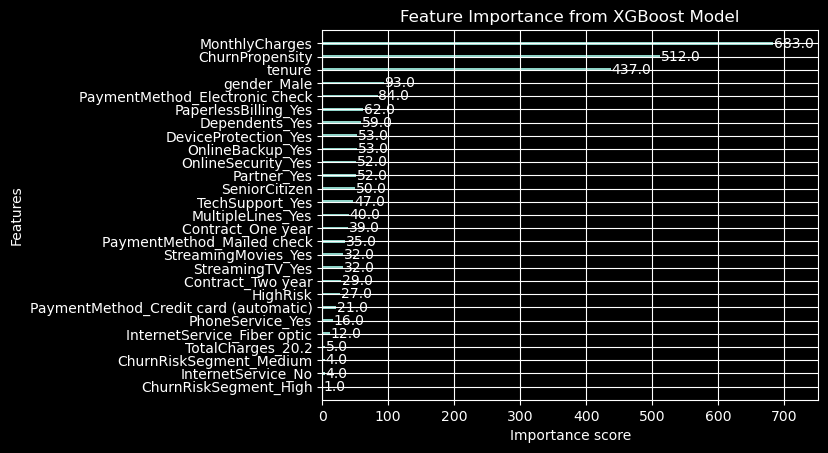

In [51]:
#predict and evaluate the xgboost model
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_xgb_pred))
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_xgb_pred))
plt.figure(figsize=(10, 10))
xgb.plot_importance(xgb_model, importance_type='weight')
plt.title("Feature Importance from XGBoost Model")
plt.show()

In [ ]:
#monthly pottential recovery from churn 
monthly_recovery = data[data['Churn'] == 'No']['MonthlyCharges'].sum()
print(f"Monthly Potential Recovery from Retained Customers: ZAR {monthly_recovery:,.2f}")

Monthly Potential Recovery from Retained Customers: ZAR 316,985.75


* Insight : Our XGBoost model identifies churn-risk customers with 72% precision and 59% recall, suggesting targeted campaigns could be efficient but still miss 4 out of 10 actual churners. Improving detection here could unlock retention for 235 customers, worth R 316, 985.75 in potential revenue recovery.

In [56]:
#save the xgboost model into a file
joblib.dump(xgb_model, 'telco_churn_xgboost_model.pkl')

['telco_churn_xgboost_model.pkl']

In [ ]:
#revenue loss   Estimated cost of churn by segment 
revenue_loss = data[data['Churn'] == 'Yes']['MonthlyCharges'].sum()
print(f"Estimated Revenue Loss from Churned Customers: ZAR {revenue_loss:,.2f}")

Estimated Revenue Loss from Churned Customers: ZAR 139,130.85


In [75]:
#save revenue loss insights to a ipynb file
revenue_loss_df = pd.DataFrame({'Estimated Revenue Loss': [revenue_loss]})
revenue_loss_df.to_csv('telco_churn_revenue_loss_insights.csv', index=False)